In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

### Делим датасет на train test

In [8]:
data = []
with open('../Datasets/list_attr_celeba.txt', 'r') as f:
    for i, line in tqdm(enumerate(f)):
        data.append(line.strip().split())

202600it [00:01, 127353.14it/s]


In [9]:
celeb_attrs = pd.DataFrame(data[1:], columns=data[0])

In [ ]:
train_files_A, test_files_A = train_test_split(celeb_attrs[celeb_attrs.Smiling == '1'].file_id.values, test_size=0.3)
train_files_B, test_files_B = train_test_split(celeb_attrs[celeb_attrs.Smiling != '1'].file_id.values, test_size=0.3)

In [3]:
# import glob
# print(glob.glob("../Datasets/train_A/*"))
import os
train_files_A = os.listdir("../Datasets/train_A/")
train_files_B = os.listdir("../Datasets/train_B/")

In [13]:
test_files_A = [file for file in celeb_attrs[celeb_attrs.Smiling == '1'].file_id.values if file not in train_files_A]

In [17]:
test_files_B = [file for file in celeb_attrs[celeb_attrs.Smiling != '1'].file_id.values if file not in train_files_B]

In [14]:
len(test_files_A)

29301

In [18]:
len(train_files_A)

68368

In [36]:
import shutil
for file_name in test_files_A:
    shutil.move('../Datasets/img_celeba/' + file_name, '../Datasets/test_A/' + file_name)
for file_name in test_files_B:
    shutil.move('../Datasets/img_celeba/' + file_name, '../Datasets/test_B/' + file_name)

### Или загружаем сохраненный

In [4]:
import sys
sys.path.append('../')

In [5]:
from CycleGAN.models import *

In [6]:
import sys
import os

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

from CycleGAN.models import Generator
from CycleGAN.datasets import ImageDataset
from PIL import Image

In [26]:
BATCHSIZE = 1
LR = 0.0002
DECAY_EPOCH  = 100
SIZE = 256
INPUT_NC = 3
OUTPUT_NC = 3
CUDA = False
N_CPU = 8
DATAROOT = '../Datasets/crop/'
GENERATOR_A2B = '../Models/CycleGan/netG_A2B-46.pth'
GENERATOR_B2A = '../Models/CycleGan/netG_B2A-46.pth'

In [17]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml -P ./
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P ./
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml -P ./

--2019-04-12 01:18:07--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: './haarcascade_eye.xml'

haarcascade_eye.xml 100%[===================>] 333.40K  1.67MB/s    in 0.2s    

2019-04-12 01:18:07 (1.67 MB/s) - './haarcascade_eye.xml' saved [341406/341406]

--2019-04-12 01:18:08--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: './haarcascade_frontalface_default.xml'

haa

In [22]:
import cv2
def crop_faces_and_save(input_path, output_path):
    image_path = input_path

    def save_faces(cascade, imgname):
        img = cv2.imread(os.path.join(image_path, imgname))
        for i, face in enumerate(cascade.detectMultiScale(img)):
            x, y, w, h = face
            sub_face = img[y:y + h, x:x + w]
            cv2.imwrite(os.path.join(output_path, "{}".format(imgname)), sub_face)
            break


    face_cascade = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(face_cascade)
    # Iterate through files
    for i, f in enumerate([f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]):
        save_faces(cascade, f)
        if i % 500 == 0:
            print(i)
        if i > 50:
            break

In [20]:
!mkdir ../Datasets/crop
!mkdir ../Datasets/crop/train_A
!mkdir ../Datasets/crop/train_B

In [23]:
crop_faces_and_save('../Datasets/train_A/', '../Datasets/crop/train_A/')

0


In [29]:
crop_faces_and_save('../Datasets/train_B/', '../Datasets/crop/train_B/')

0


In [32]:
netG_A2B = Generator(INPUT_NC, OUTPUT_NC)
netG_B2A = Generator(OUTPUT_NC, INPUT_NC)

if CUDA:
    netG_A2B.cuda()
    netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load(GENERATOR_A2B, map_location='cpu'))
netG_B2A.load_state_dict(torch.load(GENERATOR_B2A, map_location='cpu'))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if CUDA else torch.Tensor
input_A = Tensor(BATCHSIZE, INPUT_NC, SIZE, SIZE)
input_B = Tensor(BATCHSIZE, OUTPUT_NC, SIZE, SIZE)

# Dataset loader
transforms_ = [ transforms.Resize(int(SIZE*1.12), Image.BICUBIC),
                transforms.RandomCrop(SIZE),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(DATAROOT, transforms_=transforms_, mode='train'), 
                        batch_size=BATCHSIZE, shuffle=False, num_workers=N_CPU)
###################################

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))



['../Datasets/crop/train_A/000608.jpg', '../Datasets/crop/train_A/003301.jpg', '../Datasets/crop/train_A/004308.jpg', '../Datasets/crop/train_A/005770.jpg', '../Datasets/crop/train_A/007167.jpg', '../Datasets/crop/train_A/011063.jpg', '../Datasets/crop/train_A/017374.jpg', '../Datasets/crop/train_A/017412.jpg', '../Datasets/crop/train_A/018047.jpg', '../Datasets/crop/train_A/039937.jpg']


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/v.khodyreva/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/v.khodyreva/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/v.khodyreva/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/v.khodyreva/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/v.khodyreva/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/v.khodyreva/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/v

KeyboardInterrupt: 

In [45]:
B_files = sorted(os.listdir('../Datasets/crop/train_B'))
A_files = sorted(os.listdir('../Datasets/crop/train_A'))

In [37]:
from skimage.io import imshow
import matplotlib.pyplot as plt

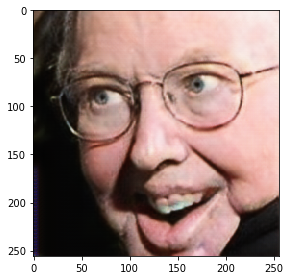

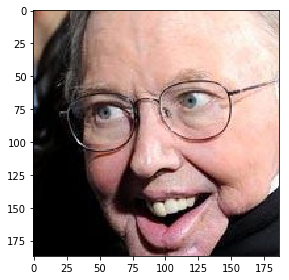

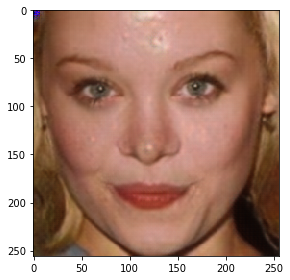

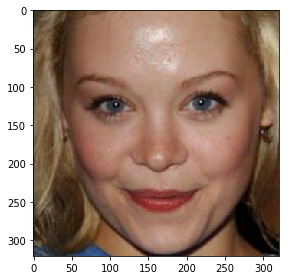

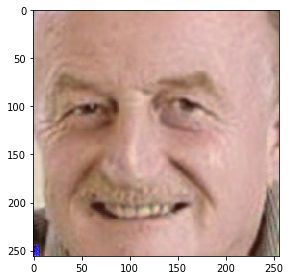

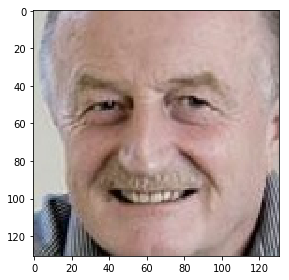

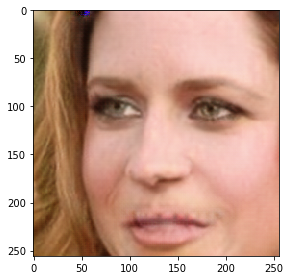

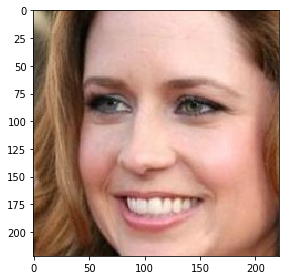

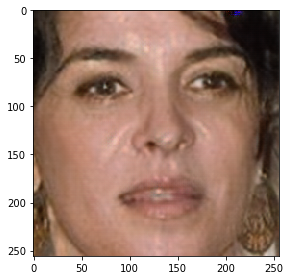

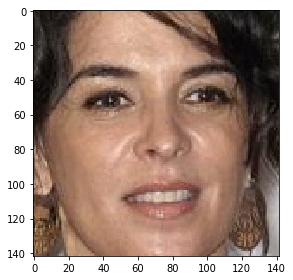

In [46]:
for i in range(1, 6):
    if i < 10:
        imshow('./output/B/000%s.png'%i)
    plt.show()
    imshow('../Datasets/crop/train_A/' + A_files[i - 1])
    plt.show()

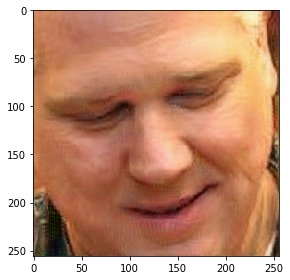

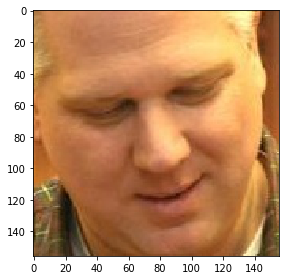

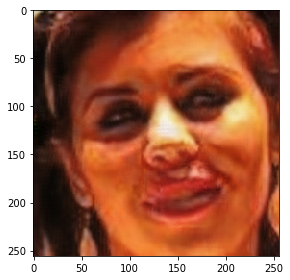

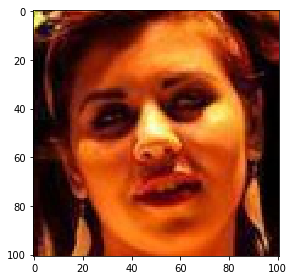

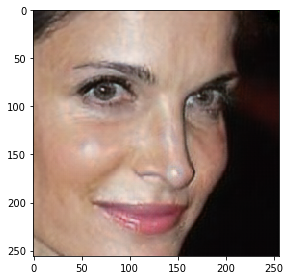

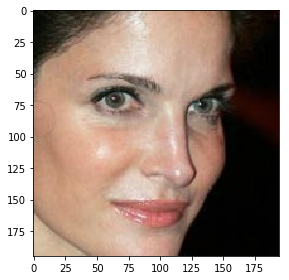

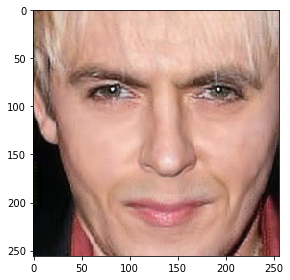

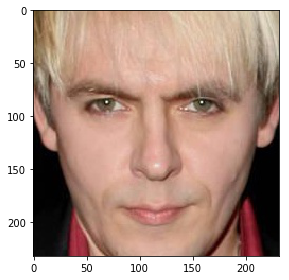

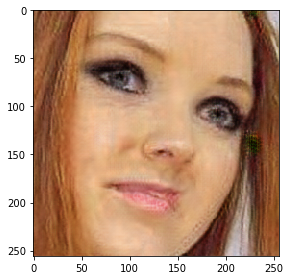

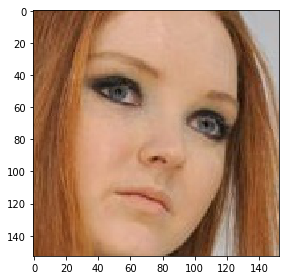

In [47]:
for i in range(1, 6):
    if i < 10:
        imshow('./output/A/000%s.png'%i)
    plt.show()
    imshow('../Datasets/crop/train_B/' + B_files[i - 1])
    plt.show()